# Game Console Prices Study

## Define Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 8
plt.rcParams["axes.grid"] = True

In [2]:
def get_data_csv(csv_file):
  """Cleans data from a CSV file.

  Args:
    csv_file: The path to the CSV file to clean.

  Returns:
    The cleaned data frame.
  """

  # Read the CSV file into a data frame.
  df = pd.read_csv(csv_file)

  return df

In [3]:
def get_data_xls(xls_file,worksheet):
  """Cleans data from a XLS file.

  Args:
    xls_file: The path to the XLS file to clean.

  Returns:
    The cleaned data frame.
  """

  # Read the CSV file into a data frame.
  df = pd.read_excel(xls_file,worksheet)

  return df

In [6]:
def get_mae(max_nodes, factors, y, df):
    #df.dropna()
    X = df[factors]
    train_X, val_X, train_y, val_y = train_test_split(X,y, random_state=7)
    #drop_missing_X(train_X,val_X)
    
    model = RandomForestRegressor(n_estimators=len(train_X), random_state=7, max_leaf_nodes=max_nodes)
    model.fit(train_X, train_y)
    model_predict = model.predict(val_X)
    error = mean_absolute_error(model_predict, val_y)
    return error

In [7]:
def clean_data_drop(df):

    # Replace any invalid values with NaN.
    for column in df.columns:
        df[column] = df[column].replace(to_replace=['-', ''], value=np.nan)
    # Drop any rows with missing values.
    df = df.dropna()
    return df

In [8]:
def test_leaf_node_number_mae(factors, y, train_data):
    for node in [25,50,60,70,80,90,100,110,120,130,150,200]:
        print(get_mae(node, factors, y, train_data))

In [9]:
def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [10]:
def create_pca(features, X):
    X = X.copy()
    X = X.loc[:, features]
    X_scaled = (X-X.mean(axis=0))/X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit(X_scaled)
    return X_pca

In [11]:
def create_pca_plot(features, X, width=8, dpi=100):
    X_pca = create_pca(features, X)
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = X_pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = X_pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [12]:
def create_pca_return_loadings(features, X):
    X = X.copy()
    X = X.reindex(columns=features)
    X_scaled = (X-X.mean(axis=0))/X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca_df = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
    )
    return loadings

In [13]:
def plot_feature_importance(model,X):
    impo_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
    impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
    impo_df.plot(kind = 'barh', figsize = (10, 10))
    plt.legend(loc = 'center right')
    plt.title('Bar chart showing feature importance', fontsize = 14)
    plt.xlabel('Features', fontsize = 12)
    plt.show()

## Clean the data

In [14]:
df = get_data_csv('data.csv')
df.head()

,Console,Year,Original Price,2020 Price
0,Magnavox Odyssey,1972,$99,$611.21
1,Atari 2600,1977,$199,$842.41
2,Intellivision,1980,$299,$916.46
3,ColecoVision,1982,$175,$465.56
4,Atari 5200,1982,$269,$713.45


In [15]:
df['Original Price'] = df['Original Price'].str.replace('$','').str.rsplit('/',1).apply(lambda x: x[0]).astype('float64')
df['2020 Price'] = df['2020 Price'].str.replace('$','').str.rsplit('/',1).apply(lambda x: x[0]).astype('float64')

C:\Users\peter\AppData\Local\Temp\ipykernel_5740\3683555703.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Original Price'] = df['Original Price'].str.replace('$','').str.rsplit('/',1).apply(lambda x: x[0]).astype('float64')
C:\Users\peter\AppData\Local\Temp\ipykernel_5740\3683555703.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['2020 Price'] = df['2020 Price'].str.replace('$','').str.rsplit('/',1).apply(lambda x: x[0]).astype('float64')


In [16]:
#df['Price Change'] = df['2020 Price'] - df['Original Price']

In [17]:
#df.head()

,Console,Year,Original Price,2020 Price,Price Change
0,Magnavox Odyssey,1972,99.0,611.21,512.21
1,Atari 2600,1977,199.0,842.41,643.41
2,Intellivision,1980,299.0,916.46,617.46
3,ColecoVision,1982,175.0,465.56,290.56
4,Atari 5200,1982,269.0,713.45,444.45


In [18]:
#df.to_csv('data_clean.csv')

In [19]:
#df_brand = pd.read_excel('data_brand.xlsx',index_col=[0])
#df_brand.head()

,Console,Year,Original Price,2020 Price,Price Change,Brand
0,Magnavox Odyssey,1972,99,611.21,512.21,Sanders Associates
1,Atari 2600,1977,199,842.41,643.41,Atari
2,Intellivision,1980,299,916.46,617.46,Mattel
3,ColecoVision,1982,175,465.56,290.56,Coleco
4,Atari 5200,1982,269,713.45,444.45,Atari


In [ ]:
#df['Adjusted Revenue'] = df['Adjusted Price'] * df['Units Sold']
#df.head()

,Console,Year,Original Price,Adjusted Price,Price Change,Brand,Units Sold,Adjusted Revenue
0,Magnavox Odyssey,1972,99,611.21,512.21,Sanders Associates,350000,2.139235e+08
1,Atari 2600,1977,199,842.41,643.41,Atari,8000000,6.739280e+09
2,Intellivision,1980,299,916.46,617.46,Mattel,3750000,3.436725e+09
3,ColecoVision,1982,175,465.56,290.56,Coleco,2000000,9.311200e+08
4,Atari 5200,1982,269,713.45,444.45,Atari,1000000,7.134500e+08


In [ ]:
#df.to_csv('data_full_new.csv')

In [135]:
df = pd.read_excel('data_full.xlsx',index_col=[0])
df.head()

,Console,Year,Original Price,Adjusted Price,Price Change,Brand,Units Sold,Adjusted Revenue,Adjusted Revenue (10s Millions)
0,Magnavox Odyssey,1972,99,611.21,512.21,Sanders Associates,350000,213923500,21.39235
1,Atari 2600,1977,199,842.41,643.41,Atari,8000000,6739280000,673.92800
2,Intellivision,1980,299,916.46,617.46,Mattel,3750000,3436725000,343.67250
3,ColecoVision,1982,175,465.56,290.56,Coleco,2000000,931120000,93.11200
4,Atari 5200,1982,269,713.45,444.45,Atari,1000000,713450000,71.34500


In [136]:
df.dtypes

Console                             object
Year                                 int64
Original Price                       int64
Adjusted Price                     float64
Price Change                       float64
Brand                               object
Units Sold                           int64
Adjusted Revenue                     int64
Adjusted Revenue (10s Millions)    float64
dtype: object

## Identify Outliers

In [137]:
def add_outlier_column(df, column):
  """Adds a column to the data frame that indicates whether the data point is an outlier.

  Args:
    df: The data frame to add the column to.
    column: The name of the column to check for outliers.

  Returns:
    The data frame with the new outlier column.
  """

  # Calculate the lower and upper bounds.
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  # Add the outlier column to the data frame.
  df['Outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)

  return df


## Describe the dataset

### All prices are adjusted for inflation

In [138]:
def describe_dataset(df):
  """Describes the dataset.

  Args:
    df: The data frame to describe.

  Returns:
    The description of the dataset.
  """
  print(df.head())
  # Print the number of rows and columns in the data frame.
  print('The data frame has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

  try:
    # Print the summary statistics for each column.
    print('Dataframe summary stats: \n' + df.describe(include='all'))
    print('Dataframe meta info: \n' + df.info())
    print('Column data types: \n' + df.dtypes)
    # Print the number of outliers in the data set.
    print('There are {} outliers in the data set.'.format(df['Outlier'].sum()))
  except:
    print('Couldnt Describe Dataset')

In [139]:
describe_dataset(df)

            Console  Year  Original Price  Adjusted Price  Price Change  \
0  Magnavox Odyssey  1972              99          611.21        512.21   
1        Atari 2600  1977             199          842.41        643.41   
2     Intellivision  1980             299          916.46        617.46   
3      ColecoVision  1982             175          465.56        290.56   
4        Atari 5200  1982             269          713.45        444.45   

                Brand  Units Sold  Adjusted Revenue  \
0  Sanders Associates      350000         213923500   
1               Atari     8000000        6739280000   
2              Mattel     3750000        3436725000   
3              Coleco     2000000         931120000   
4               Atari     1000000         713450000   

   Adjusted Revenue (10s Millions)  
0                         21.39235  
1                        673.92800  
2                        343.67250  
3                         93.11200  
4                         71.3450

In [140]:
df.describe(include='all')

,Console,Year,Original Price,Adjusted Price,Price Change,Brand,Units Sold,Adjusted Revenue,Adjusted Revenue (10s Millions)
count,32,32.00000,32.000000,32.000000,32.000000,32,3.200000e+01,3.200000e+01,32.000000
unique,32,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN
top,Magnavox Odyssey,NaN,NaN,NaN,NaN,Nintendo,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN
mean,NaN,1998.78125,307.937500,515.149688,207.212187,NaN,3.757406e+07,1.599688e+10,1599.688465
std,NaN,13.77172,139.506027,248.104638,194.158717,NaN,4.142083e+07,1.852755e+10,1852.754604
min,NaN,1972.00000,99.000000,201.450000,0.000000,NaN,1.500000e+05,6.658350e+07,6.658350
25%,NaN,1989.00000,199.000000,367.135000,54.600000,NaN,7.905000e+06,3.368347e+09,336.834735
50%,NaN,1997.50000,299.000000,444.425000,146.155000,NaN,2.101000e+07,6.539006e+09,653.900590
75%,NaN,2012.25000,399.000000,570.162500,280.537500,NaN,5.897750e+07,2.494160e+10,2494.160430


In [141]:
df.dtypes

Console                             object
Year                                 int64
Original Price                       int64
Adjusted Price                     float64
Price Change                       float64
Brand                               object
Units Sold                           int64
Adjusted Revenue                     int64
Adjusted Revenue (10s Millions)    float64
dtype: object

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Console                          32 non-null     object 
 1   Year                             32 non-null     int64  
 2   Original Price                   32 non-null     int64  
 3   Adjusted Price                   32 non-null     float64
 4   Price Change                     32 non-null     float64
 5   Brand                            32 non-null     object 
 6   Units Sold                       32 non-null     int64  
 7   Adjusted Revenue                 32 non-null     int64  
 8   Adjusted Revenue (10s Millions)  32 non-null     float64
dtypes: float64(3), int64(4), object(2)
memory usage: 2.5+ KB


## Explore Data

In [143]:
df.corr()

,Year,Original Price,Adjusted Price,Price Change,Units Sold,Adjusted Revenue,Adjusted Revenue (10s Millions)
Year,1.000000,0.358145,-0.452889,-0.836055,0.345588,0.259461,0.259461
Original Price,0.358145,1.000000,0.625796,0.081155,0.037589,0.112998,0.112998
Adjusted Price,-0.452889,0.625796,1.000000,0.828200,-0.303262,-0.182645,-0.182645
Price Change,-0.836055,0.081155,0.828200,1.000000,-0.414530,-0.314582,-0.314582
Units Sold,0.345588,0.037589,-0.303262,-0.414530,1.000000,0.960459,0.960459
Adjusted Revenue,0.259461,0.112998,-0.182645,-0.314582,0.960459,1.000000,1.000000
Adjusted Revenue (10s Millions),0.259461,0.112998,-0.182645,-0.314582,0.960459,1.000000,1.000000


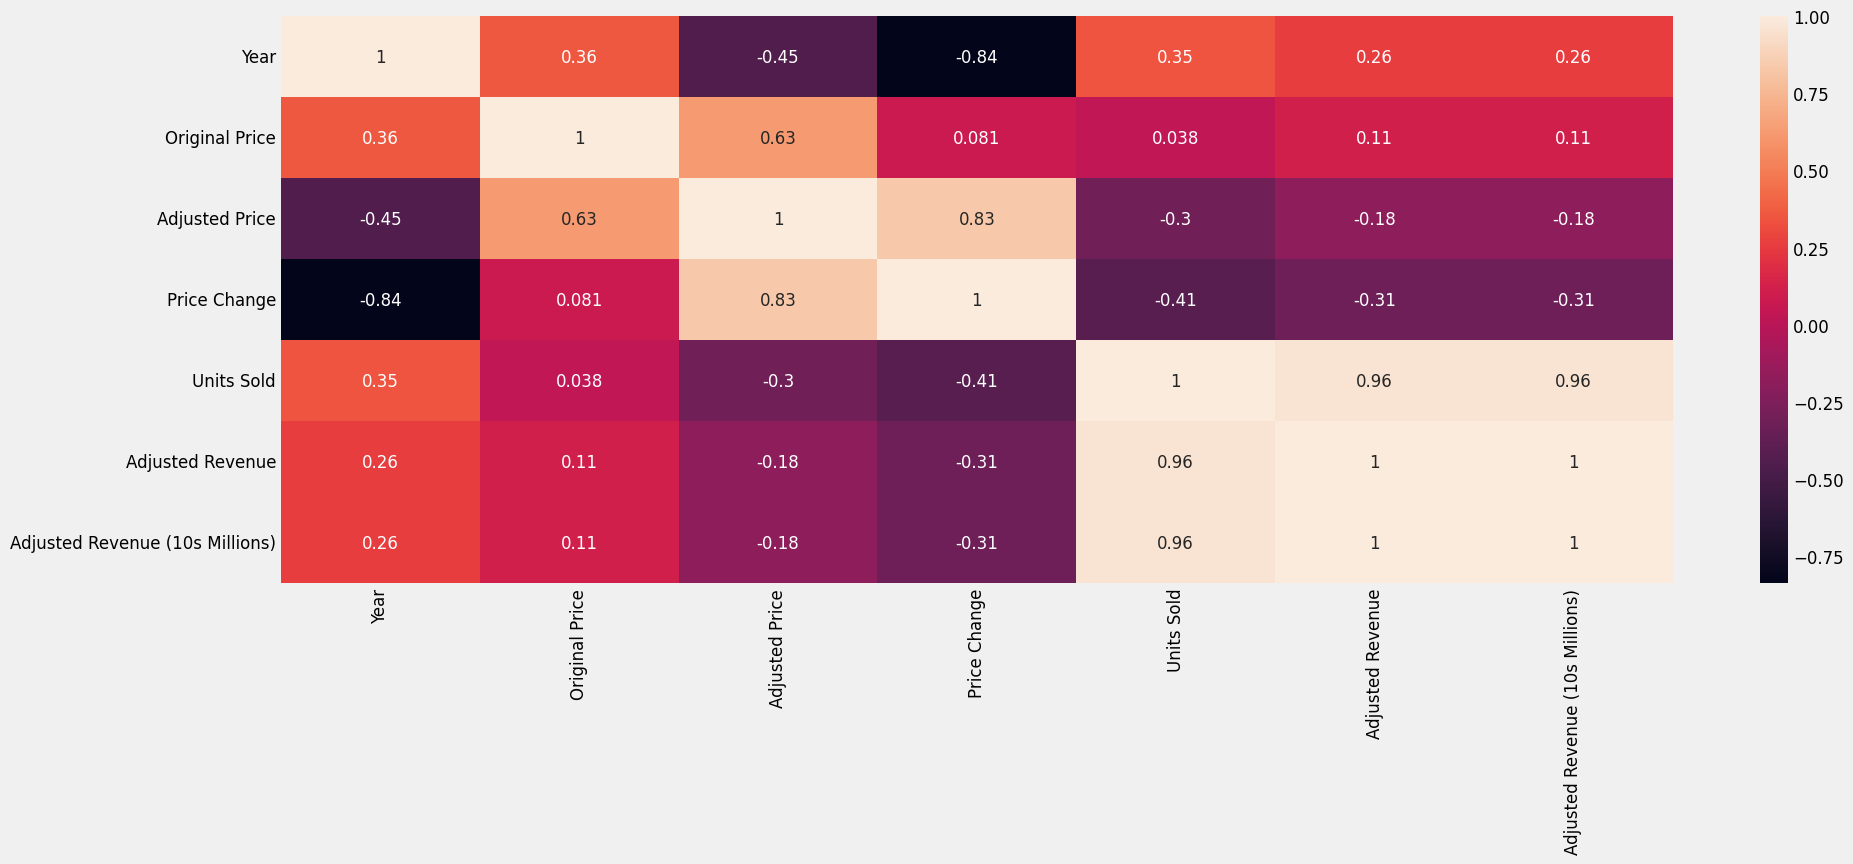

In [144]:
sns.heatmap(df.corr(), annot=True)

plt.rcParams['figure.figsize'] = (20,7)

plt.show()

In [145]:
df.sort_values(by='Price Change',ascending=False)

,Console,Year,Original Price,Adjusted Price,Price Change,Brand,Units Sold,Adjusted Revenue,Adjusted Revenue (10s Millions)
1,Atari 2600,1977,199,842.41,643.41,Atari,8000000,6739280000,673.92800
2,Intellivision,1980,299,916.46,617.46,Mattel,3750000,3436725000,343.67250
9,Neo-Geo,1991,649,1238.52,589.52,SNK Corporation,1180000,1461453600,146.14536
11,3DO,1993,699,1246.96,547.96,3DO Company,2000000,2493920000,249.39200
0,Magnavox Odyssey,1972,99,611.21,512.21,Sanders Associates,350000,213923500,21.39235
4,Atari 5200,1982,269,713.45,444.45,Atari,1000000,713450000,71.34500
3,ColecoVision,1982,175,465.56,290.56,Coleco,2000000,931120000,93.11200
14,Sega Saturn,1995,399,681.39,282.39,Sega,9260000,6309671400,630.96714
5,NES,1985,199,478.92,279.92,Nintendo,61910000,29649937200,2964.99372
6,Sega Master System,1986,199,469.36,270.36,Sega,11500000,5397640000,539.76400


### EVERY SINGLE CONSOLE experiences an increase in price

### Group Data

In [146]:
grouped_year = df.groupby('Year').mean()
print(grouped_year)

      Original Price  Adjusted Price  Price Change   Units Sold  \
Year                                                              
1972            99.0         611.210       512.210     350000.0   
1977           199.0         842.410       643.410    8000000.0   
1980           299.0         916.460       617.460    3750000.0   
1982           222.0         589.505       367.505    1500000.0   
1985           199.0         478.920       279.920   61910000.0   
1986           199.0         469.360       270.360   11500000.0   
1989           194.0         404.690       210.690   21435000.0   
1991           424.0         807.755       383.755   25140000.0   
1993           474.0         845.425       371.425    1075000.0   
1995           349.0         594.335       245.335   55875000.0   
1996           199.0         327.780       128.780   32930000.0   
1999           199.0         308.060       109.060    9130000.0   
2000           299.0         446.640       147.640  158700000.

In [147]:
grouped_brand_mean = df.groupby('Brand').agg('mean')
print(grouped_brand_mean)

                           Year  Original Price  Adjusted Price  Price Change  \
Brand                                                                           
3DO Company         1993.000000      699.000000     1246.960000    547.960000   
Atari               1984.000000      239.000000      666.583333    427.583333   
Coleco              1982.000000      175.000000      465.560000    290.560000   
Mattel              1980.000000      299.000000      916.460000    617.460000   
Microsoft           2011.200000      379.000000      442.532000     63.532000   
NEC Corporation     1989.000000      199.000000      415.120000    216.120000   
Nintendo            2003.375000      230.250000      331.780000    101.530000   
SNK Corporation     1991.000000      649.000000     1238.520000    589.520000   
Sanders Associates  1972.000000       99.000000      611.210000    512.210000   
Sega                1992.250000      246.500000      463.267500    216.767500   
Sony                2008.333

In [148]:
grouped_brand_size = df.groupby('Brand').agg('count')[['Console']]
print(grouped_brand_size)

                    Console
Brand                      
3DO Company               1
Atari                     3
Coleco                    1
Mattel                    1
Microsoft                 5
NEC Corporation           1
Nintendo                  8
SNK Corporation           1
Sanders Associates        1
Sega                      4
Sony                      6


In [168]:
nintendo = ['Nintendo']
df_nintendo = df[df['Brand'].isin(nintendo)]
df_nintendo = df_nintendo.set_index('Year')
df_nintendo['revenue_rolling'] = df_nintendo['Adjusted Revenue (10s Millions)'].rolling(2).mean()
df_nintendo['units_rolling'] = df_nintendo['Units Sold'].rolling(2).mean()
print(df_nintendo)


                   Console  Original Price  Adjusted Price  Price Change  \
Year                                                                       
1985                   NES             199          478.92        279.92   
1991                  SNES             199          376.99        177.99   
1996           Nintendo 64             199          327.78        128.78   
2001              GameCube             199          291.57         92.57   
2006                   Wii             249          321.19         72.19   
2012                 Wii U             299          337.57         38.57   
2017       Nintendo Switch             299          318.77         19.77   
2019  Nintendo Switch Lite             199          201.45          2.45   

         Brand  Units Sold  Adjusted Revenue  Adjusted Revenue (10s Millions)  \
Year                                                                            
1985  Nintendo    61910000       29649937200                       2964.99372

In [167]:
sony = ['Sony']
df_sony = df[df['Brand'].isin(sony)]
df_sony = df_sony.set_index('Year')
df_sony['revenue_rolling'] = df_sony['Adjusted Revenue (10s Millions)'].rolling(2).mean()
df_sony['units_rolling'] = df_sony['Units Sold'].rolling(2).mean()
print(df_sony)

                         Console  Original Price  Adjusted Price  \
Year                                                               
1995                 PlayStation             299          507.28   
2000               PlayStation 2             299          446.64   
2006               PlayStation 3             499          643.67   
2013               PlayStation 4             399          444.96   
2016           PlayStation 4 Pro             399          429.69   
2020  PlayStation 5 Digital/Disc             399          399.00   

      Price Change Brand  Units Sold  Adjusted Revenue  \
Year                                                     
1995        208.28  Sony   102490000       51991127200   
2000        147.64  Sony   158700000       70881768000   
2006        144.67  Sony    87400000       56256758000   
2013         45.96  Sony   100000000       44496000000   
2016         30.69  Sony    17000000        7304730000   
2020          0.00  Sony    41700000       153216

In [165]:
xbox = ['Microsoft']
df_xbox = df[df['Brand'].isin(xbox)]
df_xbox = df_xbox.set_index('Year')
df_xbox['revenue_rolling'] = df_xbox['Adjusted Revenue (10s Millions)'].rolling(2).mean()
df_xbox['units_rolling'] = df_xbox['Units Sold'].rolling(2).mean()
print(df_xbox)

              Console  Original Price  Adjusted Price  Price Change  \
Year                                                                  
2001             Xbox             299          438.08        139.08   
2005         Xbox 360             299          393.30         94.30   
2013         Xbox One             499          556.48         57.48   
2017       Xbox One X             499          525.80         26.80   
2020  Xbox Series S/X             299          299.00          0.00   

          Brand  Units Sold  Adjusted Revenue  \
Year                                            
2001  Microsoft    24000000       10513920000   
2005  Microsoft    84000000       33037200000   
2013  Microsoft    58000000       23372160000   
2017  Microsoft    10000000        5258000000   
2020  Microsoft    21000000        6279000000   

      Adjusted Revenue (10s Millions)  revenue_rolling  units_rolling  
Year                                                                   
2001          

## Plot Data

In [152]:
def my_plotter(ax, data1, data2, param_dict):
    """
    A helper function to make a graph.
    """
    out = ax.plot(data1, data2, **param_dict)
    
    """ 
    example usage for 2 plots:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.7))
    my_plotter(ax1, data1, data2, {'marker': 'x','color':'orange'})
    my_plotter(ax2, data3, data4, {'marker': 'o','color':'blue'})

    can change .plot for different types of graphs

    """

    return out    


Text(0, 0.5, 'Average Change in Price')

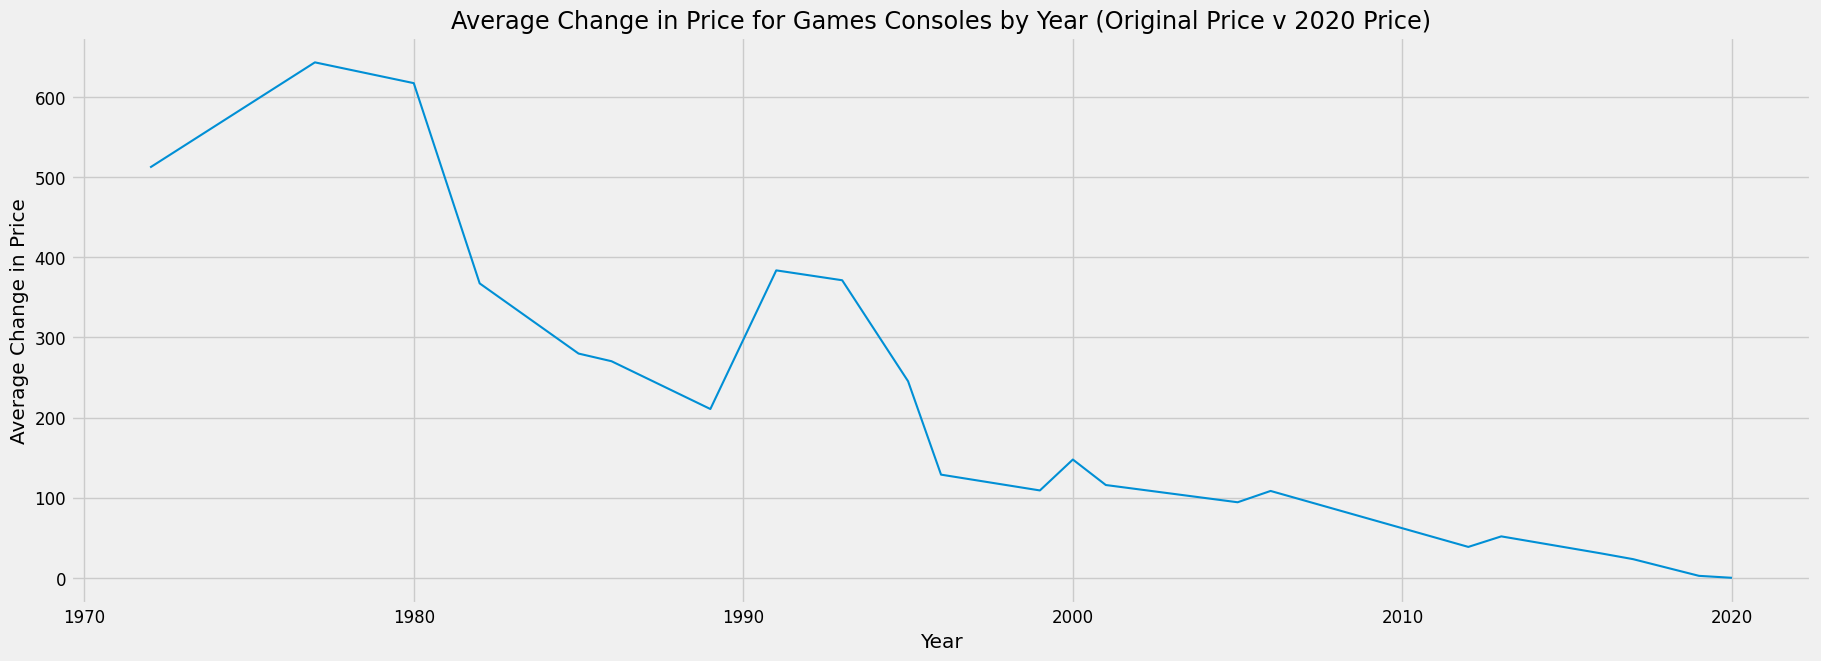

In [153]:
fig, ax = plt.subplots()
ax.plot(grouped_year.index,grouped_year['Price Change'])
ax.set_title('Average Change in Price for Games Consoles by Year (Original Price v 2020 Price)')
ax.set_xlabel('Year')
ax.set_ylabel('Average Change in Price')

C:\Users\peter\AppData\Local\Temp\ipykernel_5740\4115917601.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grouped_brand_size.index,rotation=45, ha='right')


Text(0, 0.5, 'Number of Home Consoles')

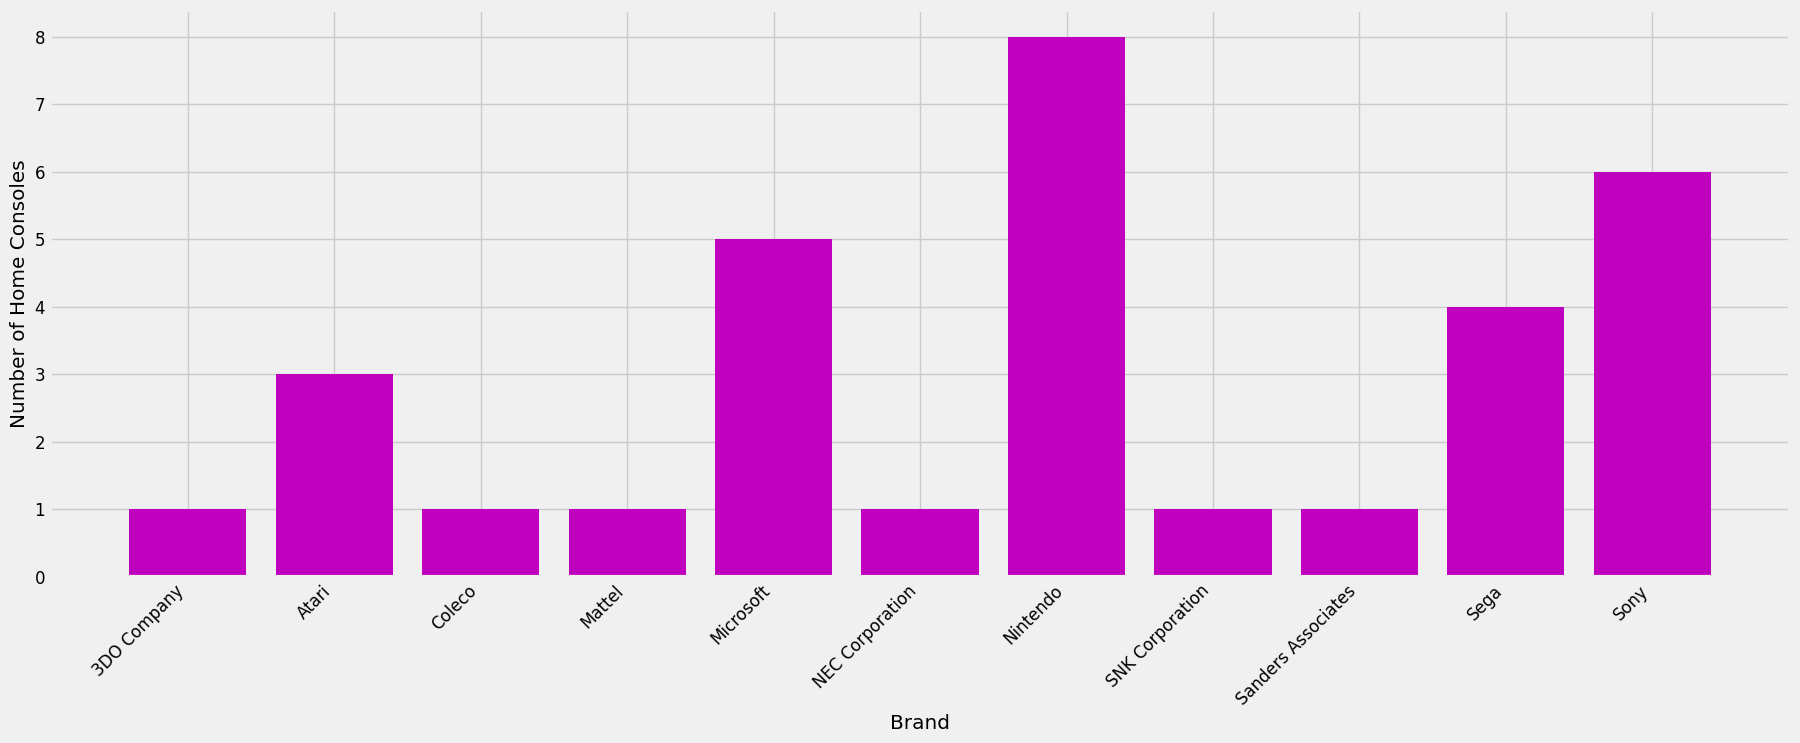

In [154]:
fig, ax = plt.subplots()

ax.bar(grouped_brand_size.index,grouped_brand_size['Console'],color='m')
ax.set_xticklabels(grouped_brand_size.index,rotation=45, ha='right')
ax.set_xlabel('Brand')
ax.set_ylabel('Number of Home Consoles')

C:\Users\peter\AppData\Local\Temp\ipykernel_5740\2113458948.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')
C:\Users\peter\AppData\Local\Temp\ipykernel_5740\2113458948.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')


Text(0, 0.5, 'Average Adjusted Price ($)')

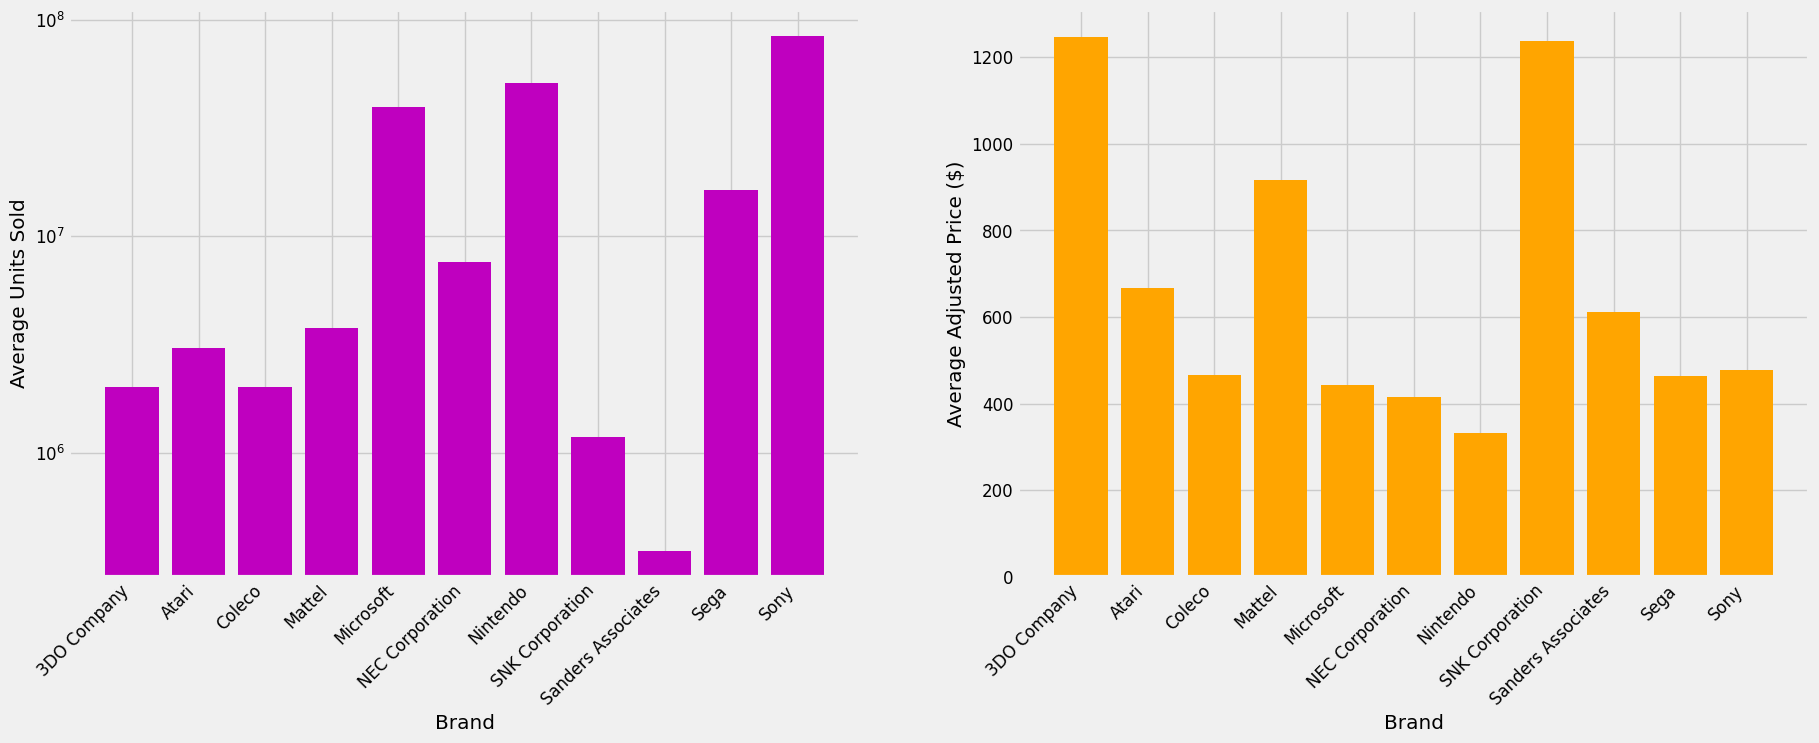

In [155]:
fig, ax = plt.subplots(1,2)

ax[0].bar(grouped_brand_mean.index,grouped_brand_mean['Units Sold'],log=True,color='m')
ax[0].set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')
ax[0].set_xlabel('Brand')
ax[0].set_ylabel('Average Units Sold')

ax[1].bar(grouped_brand_mean.index,grouped_brand_mean['Adjusted Price'],color='orange')
ax[1].set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')
ax[1].set_xlabel('Brand')
ax[1].set_ylabel('Average Adjusted Price ($)')

C:\Users\peter\AppData\Local\Temp\ipykernel_5740\2565637034.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')


Text(0.5, 1.0, 'Average Revenue by Brand (Adjusted for inflation)')

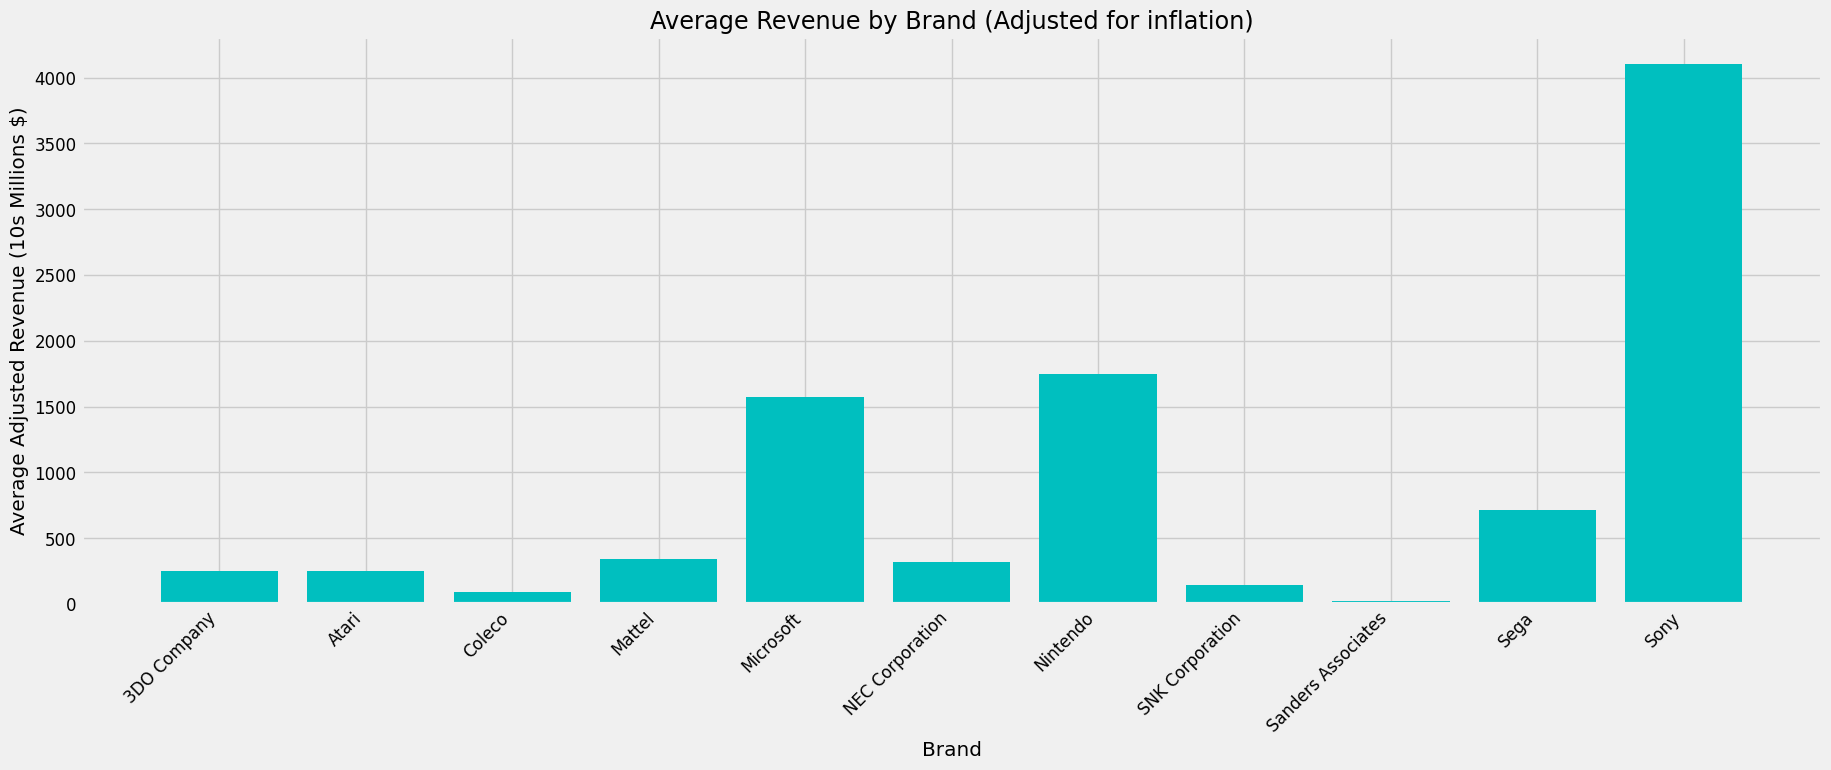

In [156]:
fig, ax = plt.subplots()
ax.bar(grouped_brand_mean.index,grouped_brand_mean['Adjusted Revenue (10s Millions)'], color='c')
ax.set_xticklabels(grouped_brand_mean.index,rotation=45, ha='right')
ax.set_ylabel('Average Adjusted Revenue (10s Millions $)')
ax.set_xlabel('Brand')
ax.set_title('Average Revenue by Brand (Adjusted for inflation)')

Text(0.5, 1.0, 'Average Revenue by Year (Adjusted for inflation)')

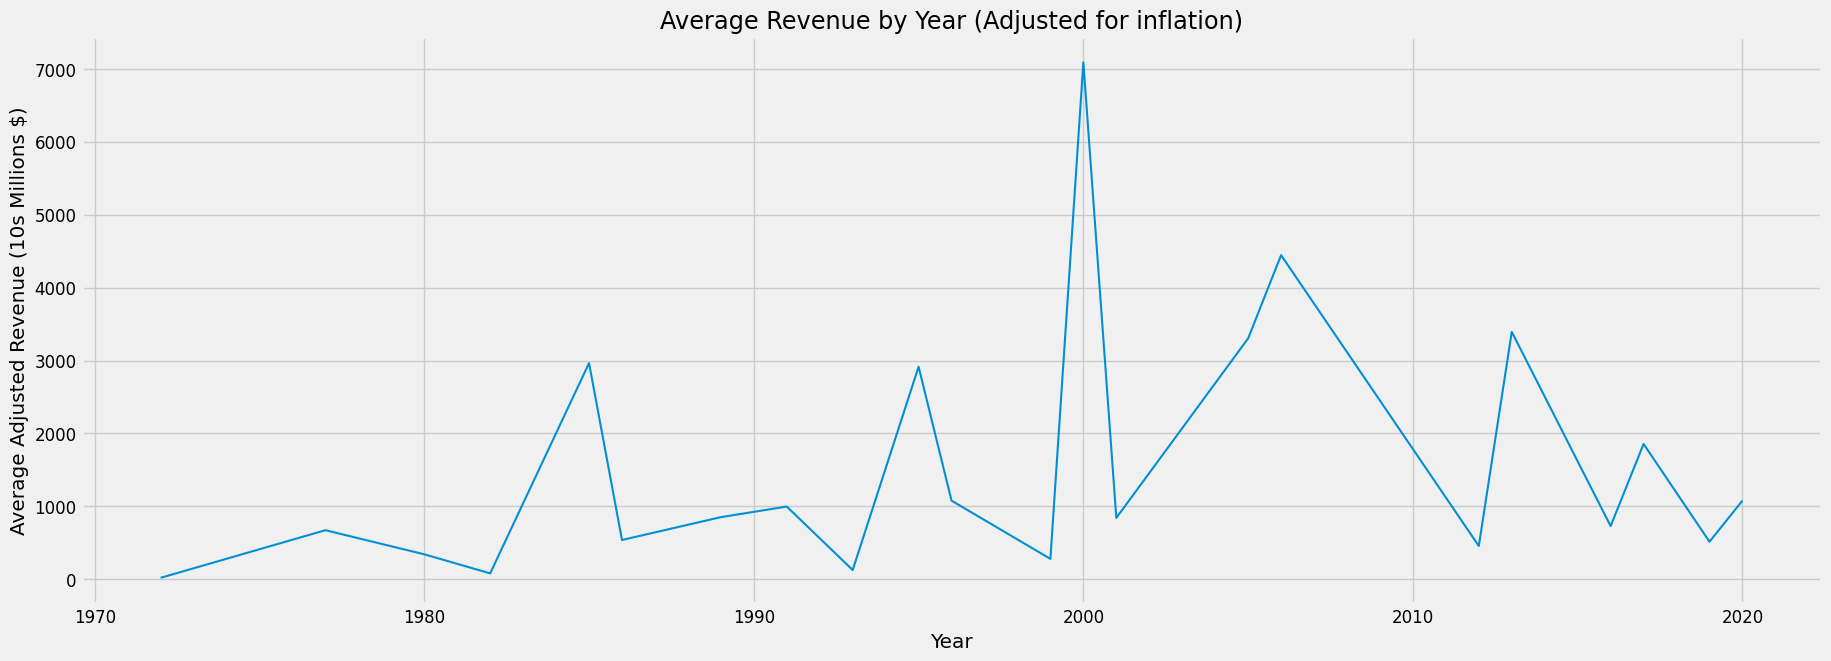

In [157]:
fig, ax = plt.subplots()
ax.plot(grouped_year.index,grouped_year['Adjusted Revenue (10s Millions)'])
ax.set_ylabel('Average Adjusted Revenue (10s Millions $)')
ax.set_xlabel('Year')
ax.set_title('Average Revenue by Year (Adjusted for inflation)')

Text(0.5, 1.0, 'Average Revenue by Year for Sony (Adjusted for inflation)')

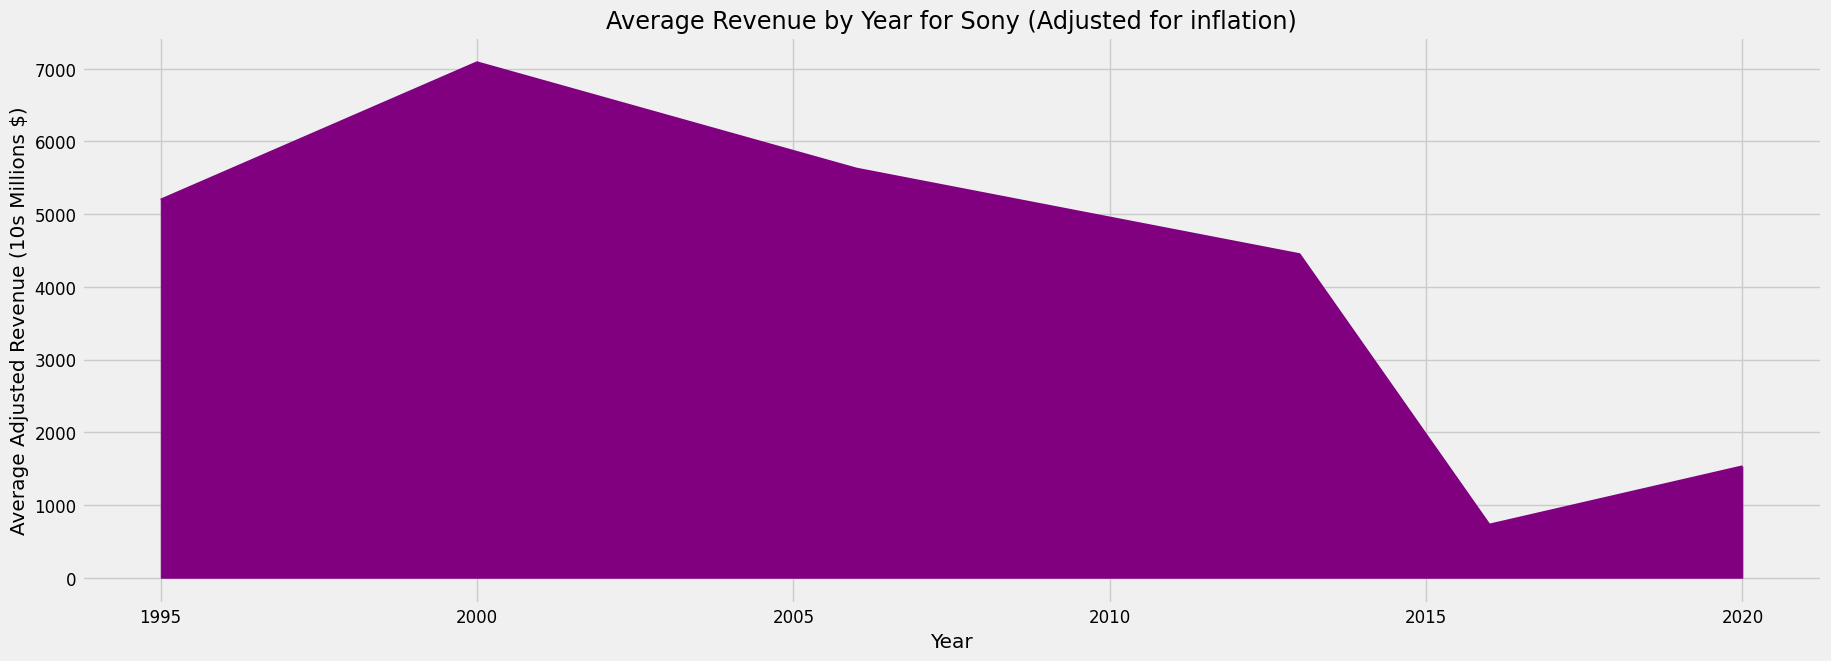

In [158]:
grouped_year_sony = df[df['Brand'] == 'Sony'].groupby('Year').mean()

fig, ax = plt.subplots()
ax.plot(grouped_year_sony.index,grouped_year_sony['Adjusted Revenue (10s Millions)'], color='purple')
ax.fill_between(grouped_year_sony.index,grouped_year_sony['Adjusted Revenue (10s Millions)'], color='purple')
ax.set_ylabel('Average Adjusted Revenue (10s Millions $)')
ax.set_xlabel('Year')
ax.set_title('Average Revenue by Year for Sony (Adjusted for inflation)')

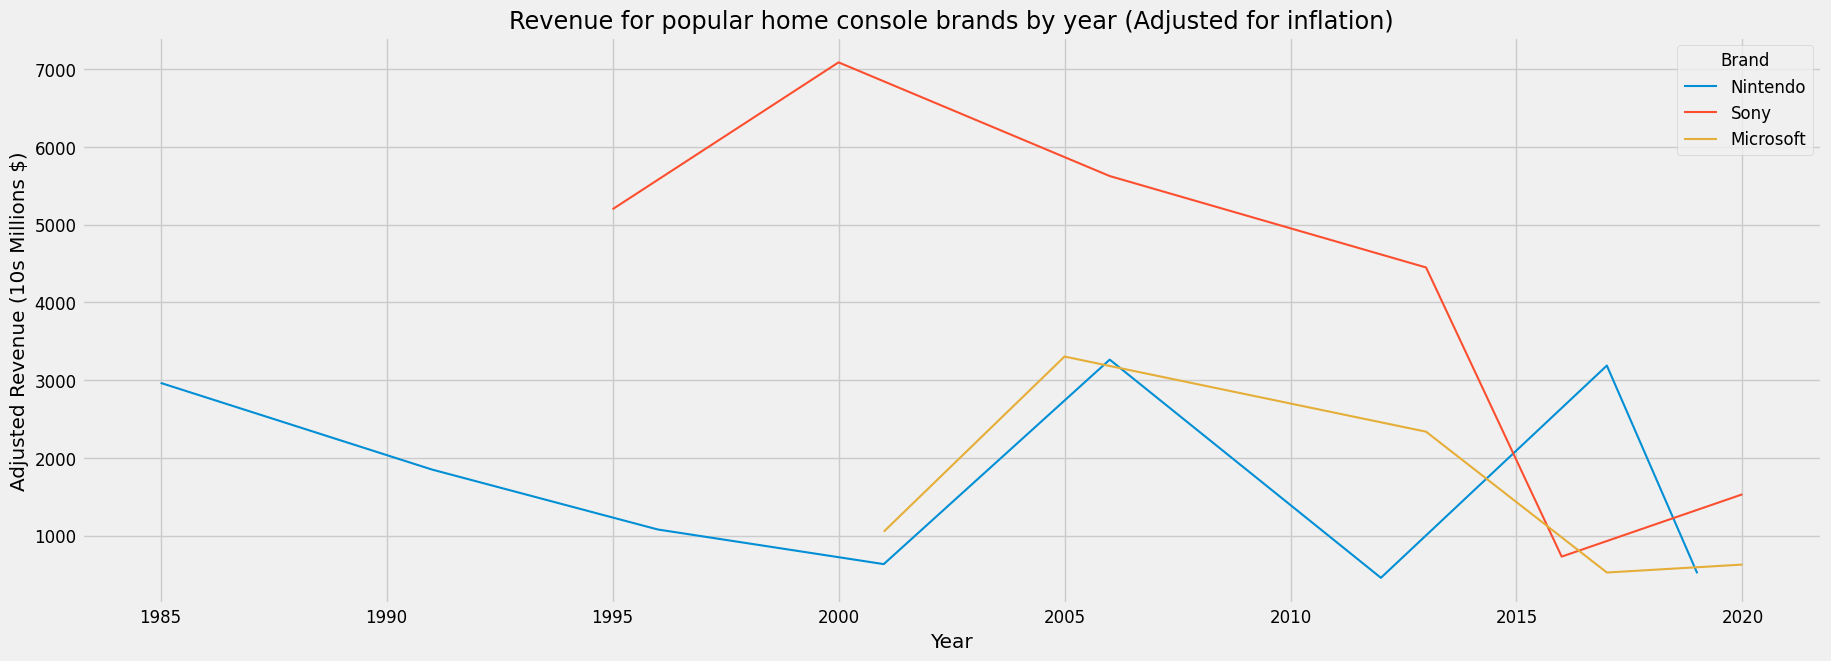

In [159]:
top_brands = ['Sony','Microsoft','Nintendo']
df_top_brands = df[df['Brand'].isin(top_brands)]

sns.lineplot(df_top_brands,x='Year',y='Adjusted Revenue (10s Millions)',hue='Brand')
plt.title('Revenue for popular home console brands by year (Adjusted for inflation)')
plt.xlabel("Year")
plt.ylabel("Adjusted Revenue (10s Millions $)")
plt.legend().set_title('Brand')
plt.show()

In [160]:
pivot = pd.pivot_table(df_top_brands,'Adjusted Revenue (10s Millions)',['Year','Brand'])
print(pivot)

                Adjusted Revenue (10s Millions)
Year Brand                                     
1985 Nintendo                        2964.99372
1991 Nintendo                        1851.02090
1995 Sony                            5199.11272
1996 Nintendo                        1079.37954
2000 Sony                            7088.17680
2001 Microsoft                       1051.39200
     Nintendo                         633.87318
2005 Microsoft                       3303.72000
2006 Nintendo                        3264.25397
     Sony                            5625.67580
2012 Nintendo                         457.74492
2013 Microsoft                       2337.21600
     Sony                            4449.60000
2016 Sony                             730.47300
2017 Microsoft                        525.80000
     Nintendo                        3187.70000
2019 Nintendo                         516.11490
2020 Microsoft                        627.90000
     Sony                            153

In [161]:
df_year_brand = df.set_index(['Year','Brand'])
print(df_year_brand)

                                            Console  Original Price  \
Year Brand                                                            
1972 Sanders Associates            Magnavox Odyssey              99   
1977 Atari                               Atari 2600             199   
1980 Mattel                           Intellivision             299   
1982 Coleco                            ColecoVision             175   
     Atari                               Atari 5200             269   
1985 Nintendo                                   NES             199   
1986 Sega                        Sega Master System             199   
1989 NEC Corporation                  TurboGrafx-16             199   
     Sega                              Sega Genesis             189   
1991 SNK Corporation                        Neo-Geo             649   
     Nintendo                                  SNES             199   
1993 3DO Company                                3DO             699   
     A

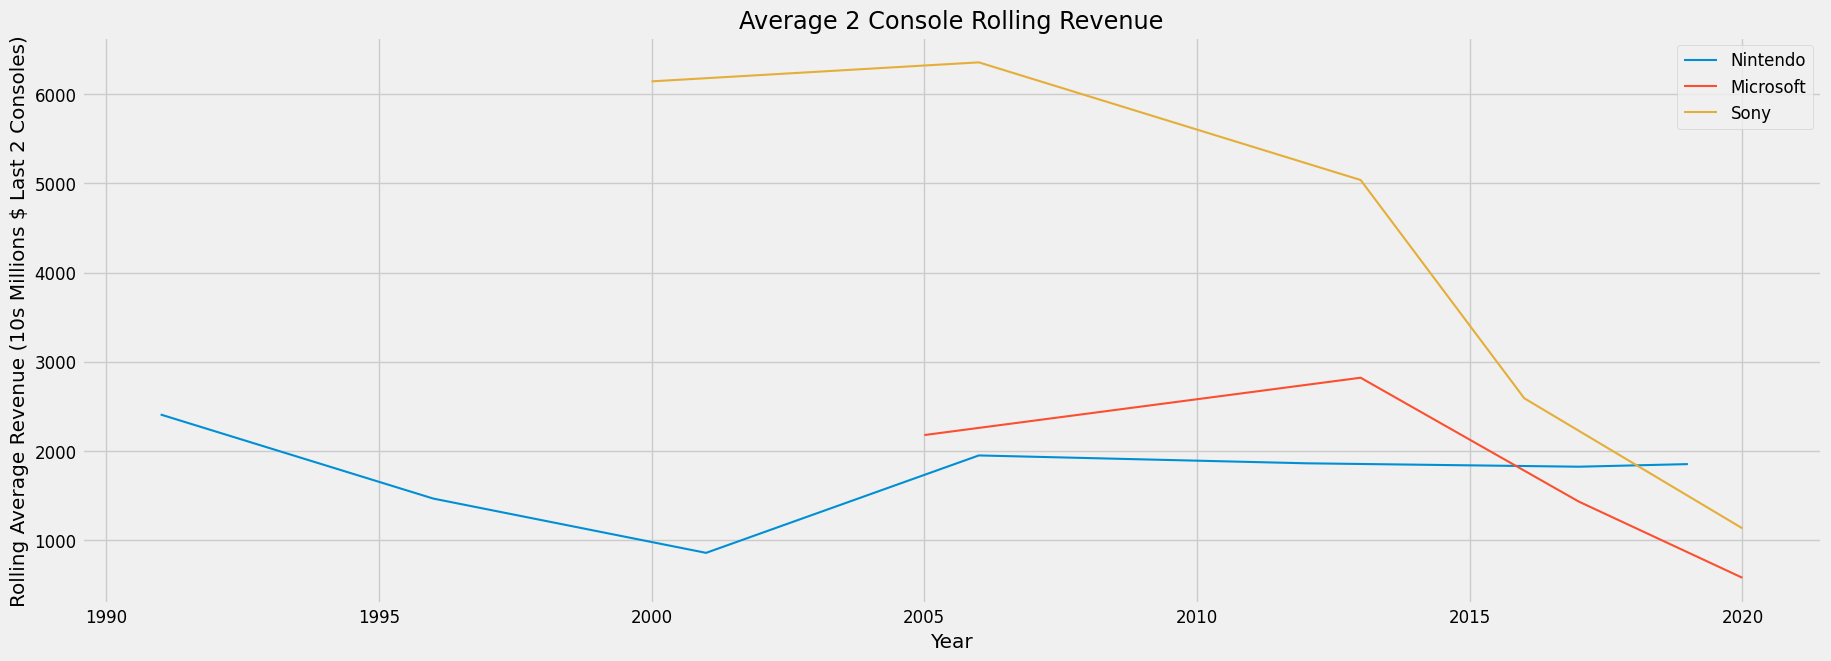

In [163]:
plt.plot(df_nintendo.index,df_nintendo['revenue_rolling'],label='Nintendo')
plt.plot(df_xbox.index,df_xbox['revenue_rolling'],label='Microsoft')
plt.plot(df_sony.index,df_sony['revenue_rolling'],label='Sony')
plt.xlabel('Year')
plt.ylabel('Rolling Average Revenue (10s Millions $ Last 2 Consoles)')
plt.title('Average 2 Console Rolling Revenue')
plt.legend()
plt.show()

### Nintendo are the current console king

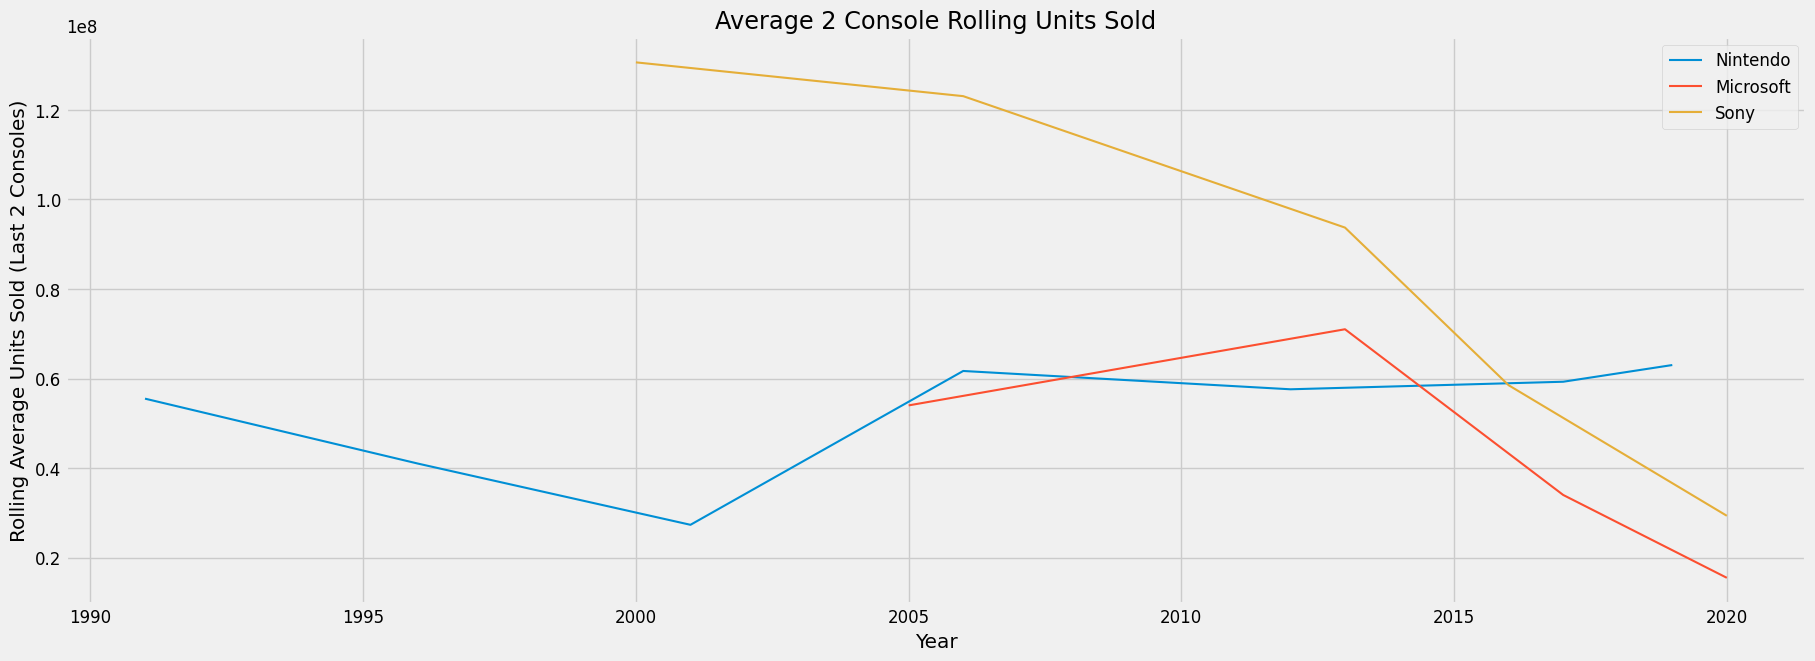

In [170]:
plt.plot(df_nintendo.index,df_nintendo['units_rolling'],label='Nintendo')
plt.plot(df_xbox.index,df_xbox['units_rolling'],label='Microsoft')
plt.plot(df_sony.index,df_sony['units_rolling'],label='Sony')
plt.xlabel('Year')
plt.ylabel('Rolling Average Units Sold (Last 2 Consoles)')
plt.title('Average 2 Console Rolling Units Sold')
plt.legend()
plt.show()

## Predict / Model

- plot predicted revenue for sony
- plot predicted revenue nintendo
- plot overall predicted revenue

In [ ]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()


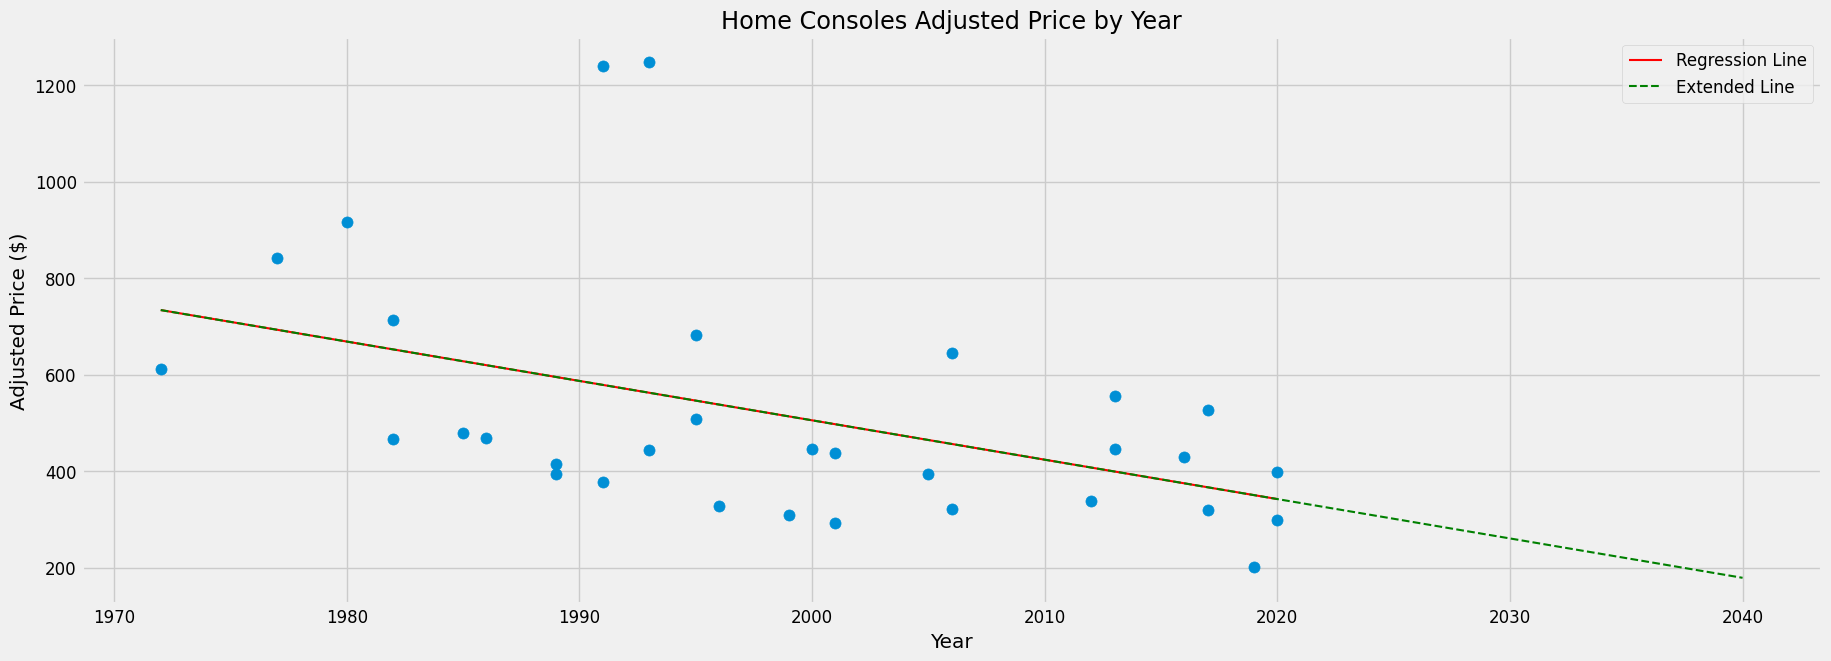

In [104]:
x = df['Year'].array.reshape(-1,1)
y = df['Adjusted Price'].array.reshape(-1,1)

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Compute the predicted values
y_pred = model.predict(x)

# Extend the regression line
x_ext = np.linspace(x.min(), x.max()+20, 100).reshape(-1, 1) #linspace generate evenly spaced datapoints, shape them into column
y_ext = model.predict(x_ext) #use model to predict value for the generated datapoints above

plt.scatter(x,y)
plt.plot(x,y_pred,'r',label='Regression Line')
plt.plot(x_ext,y_ext,'g--',label='Extended Line')
plt.xlabel('Year')
plt.ylabel('Adjusted Price ($)')
plt.title('Home Consoles Adjusted Price by Year')
plt.legend()
plt.show()

### Average price of a console in 2040 will be around 200 Dollars

### Consoles are getting cheaper!

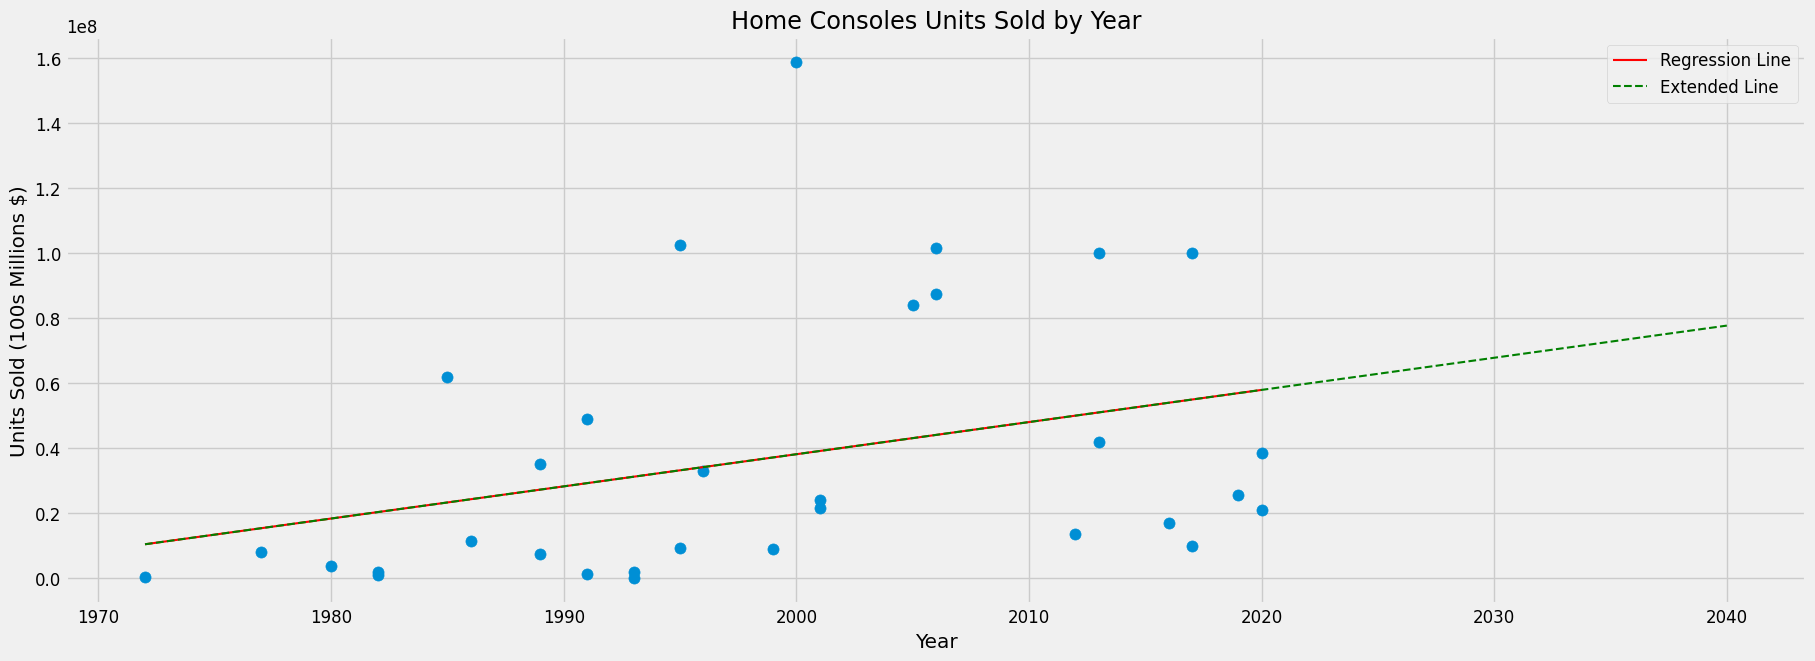

In [134]:
x = df['Year'].array.reshape(-1,1)
y = df['Units Sold'].array.reshape(-1,1)

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Compute the predicted values
y_pred = model.predict(x)

# Extend the regression line
x_ext = np.linspace(x.min(), x.max()+20, 100).reshape(-1, 1) #linspace generate evenly spaced datapoints, shape them into column
y_ext = model.predict(x_ext) #use model to predict value for the generated datapoints above

plt.scatter(x,y)
plt.plot(x,y_pred,'r',label='Regression Line')
plt.plot(x_ext,y_ext,'g--',label='Extended Line')
plt.xlabel('Year')
plt.ylabel('Units Sold (100s Millions $)')
plt.title('Home Consoles Units Sold by Year')
plt.legend()
plt.show()

# example data manipulation

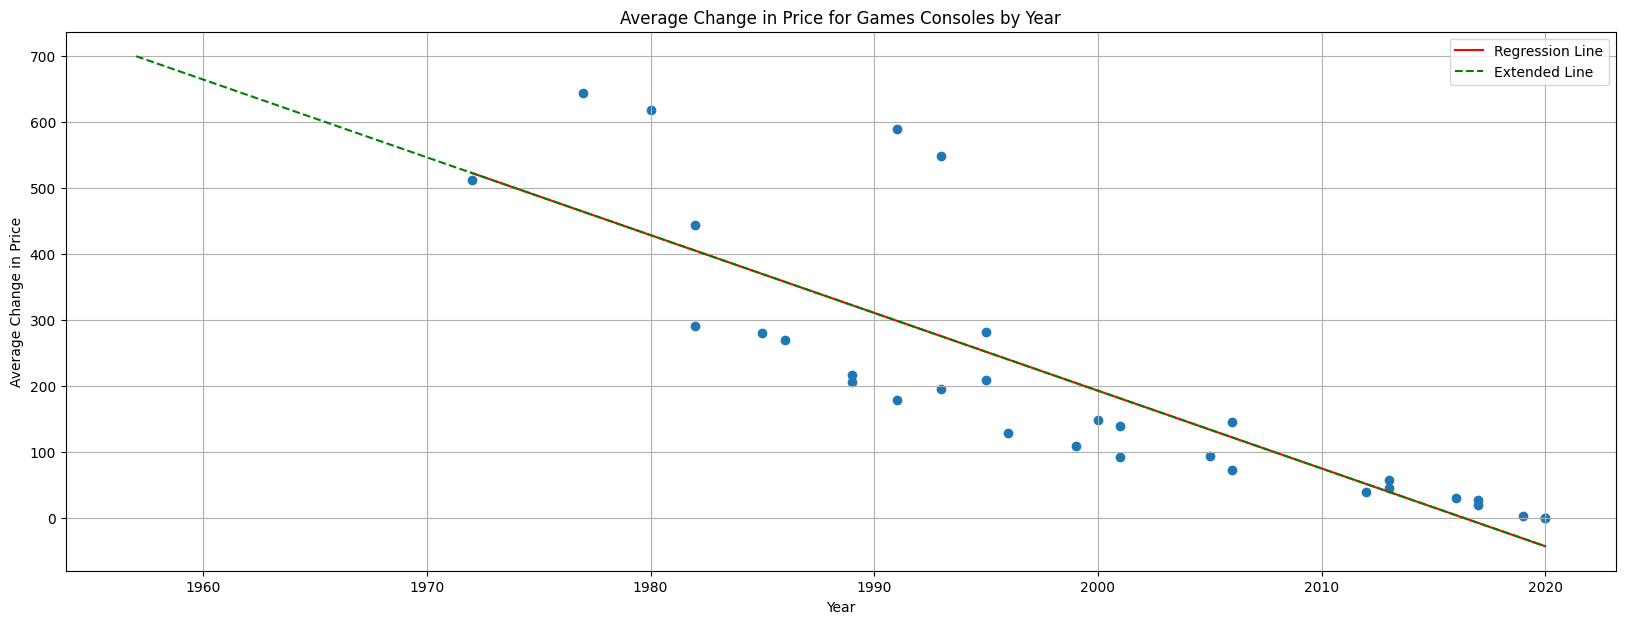

In [57]:
"""
example creating line of best fit using linear regression, and then extending the line beyond available data points
"""
x = df['Year'].array.reshape(-1,1) #reshape into column vector -1 means auto work out rows, 1 means 1 column
y = df['Price Change'].array.reshape(-1,1)
# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Compute the predicted values
y_pred = model.predict(x)

# Extend the regression line
x_ext = np.linspace(x.min()-15, x.max(), 100).reshape(-1, 1) #linspace generate evenly spaced datapoints, shape them into column
y_ext = model.predict(x_ext) #use model to predict value for the generated datapoints above

# Plot the extended line
plt.scatter(x, y)
plt.plot(x, y_pred, 'r', label='Regression Line')
plt.plot(x_ext, y_ext, 'g--', label='Extended Line')
plt.title('Average Change in Price for Games Consoles by Year')
plt.xlabel('Year')
plt.ylabel('Average Change in Price')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def calculate_demographic_data(print_data=True):
    # Read data from file
    df = pd.read_csv('adult.data.csv')

    # How many of each race are represented in this dataset? This should be a Pandas series with race names as the index labels.
    race_count = df.groupby('race')['race'].count()

    # What is the average age of men?
    average_age_men = round(df[df['sex'] == 'Male']['age'].mean(),1)

    # What is the percentage of people who have a Bachelor's degree?
    percentage_bachelors = round(len(df[df['education'] == 'Bachelors']['education']) / len(df) * 100,1)

    # What percentage of people with advanced education (`Bachelors`, `Masters`, or `Doctorate`) make more than 50K?
    # What percentage of people without advanced education make more than 50K?

    # with and without `Bachelors`, `Masters`, or `Doctorate`
    higher_education = df[(df['education'] == 'Bachelors') | (df['education'] == 'Masters') | (df['education'] == 'Doctorate')]
    lower_education = df[~(df['education'] == 'Bachelors') & ~(df['education'] == 'Masters') & ~(df['education'] == 'Doctorate')]

    # percentage with salary >50K
    higher_education_rich = round(higher_education[higher_education['salary'] == '>50K']['salary'].count() / len(higher_education) * 100,1)
    lower_education_rich = round(lower_education[lower_education['salary'] == '>50K']['salary'].count() / len(lower_education) * 100,1)

    # What is the minimum number of hours a person works per week (hours-per-week feature)?
    min_work_hours = df['hours-per-week'].min()

    # What percentage of the people who work the minimum number of hours per week have a salary of >50K?
    num_min_workers = df[df['hours-per-week'] == 1]

    rich_percentage = len(num_min_workers[num_min_workers['salary'] == '>50K']) / len(num_min_workers) * 100

    # What country has the highest percentage of people that earn >50K?
    highest_earning_country = ((df[df['salary'] == '>50K'].groupby('native-country').size() / df.groupby('native-country').size()) * 100).sort_values(ascending=False).index[0]
    
    highest_earning_country_percentage = round(((df[df['salary'] == '>50K'].groupby('native-country').size() / df.groupby('native-country').size()) * 100).sort_values(ascending=False)[0],1)
    # Identify the most popular occupation for those who earn >50K in India.
    top_IN_occupation = df[(df['salary'] == '>50K') & (df['native-country'] == 'India')].groupby('occupation').size().sort_values(ascending=False).index[0]